# Credit Card Fraud Detection
## Wykrywanie oszustw związanych z kartami kredytowymi


Analizie zostanie poddany zbiór danych zawierający transakcje dokonane kartami kredytowymi we wrześniu 2013r. przez europejczyków w ciągu 2 dni.

Celem zadania jest:

     1) Dokonaj eksploracyjnej analizy danych oraz opisz wnioski i obserwacje;
     2) Stwórz model predykcyjny, który w skuteczny sposób będzie wskazywał podejrzane transakcje;
     3) Dokonać analizy wyników 
     
 Dane pobrane ze strony: https://www.kaggle.com/mlg-ulb/creditcardfraud

## Library - biblioteki 
Wszystkie biblioteki potrzebne do prawidłowego działania kodu znajdują się tutaj.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

## 1) Introduction - Wprowadzenie 

Na podstawie informacji znajdujących się przy danych wiemy, że tabela zawiera 31 kolumn z pośród których możemy wyszczególnić: 
    - Time - liczba sekund, która upłyneła między badaną tranzakcją a pierwszą transakcją w zestawieniu;
    - Kwota - kwota tranzakcji;
    - Klasa - 1 w przypadku oszustwa, 0 w pozostałych przypadkach
    - V1-V28 - przeskalowane, nieopisane dane w celu ochrony danych osobowych
I każda z kolumn zawiera 284807 wierszy.

## 2) First look on the data - Podstawowa analiza danych 
### Podsumowanie zdobytych informacji
    1) Rozmiar danych 284807 wierszy, 31 kolumn
    2) 492(0.1723%) transakcje to oszustwa, a pozostałe 284315(99.823%) transakcji to prawidłowe transakcje
    3) Dane nie zawierają żadnych wybrakowanych wartości.
    4) Analiza histogramu oraz boxplota dla zmiennej "Amount" wynika, że mamy doczynienia z bardzo dużą liczbą małych tranzakcji
    5) Analiza histogramu dla zmiennej "Time" można zauważyć, że podczas dnia jest wykonywane zdecydowanie więcej tranzakcji niż nocą;
    6) Macierz korelacji pokazała, że żadna z kolumn nie jest na tyle skorelowana z Klasą, żeby brać ją pod uwagę.

#### Załadowanie danych 

In [2]:
df = pd.read_csv("Data/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

#### Opis prawidłowych tranzakcji i oszustw

In [5]:
df_no_flaud = df[df.Class == 0]
df_no_flaud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


In [6]:
df_flaud = df[df.Class == 1]
df_flaud.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


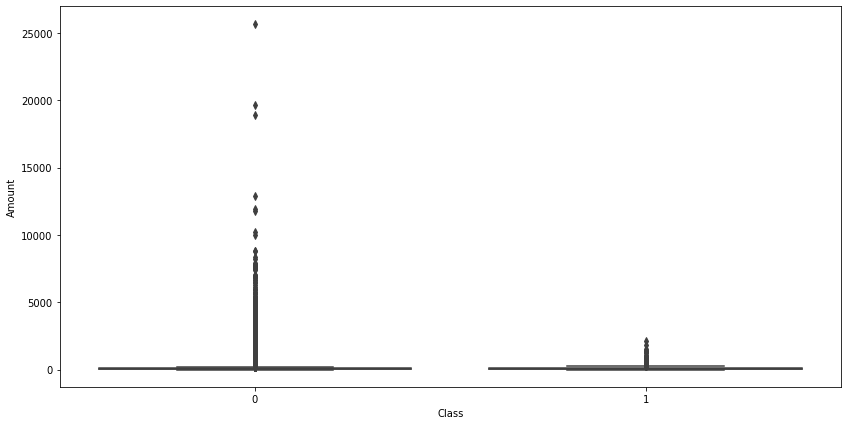

In [7]:
plt.figure(figsize=(14,7))
sns.boxplot(x='Class', y='Amount', data=df)

#### Ilość oszustw 

In [8]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

#### Procentowa ilość oszustw 

In [9]:
print(df.Class.value_counts()[0]/len(df))
print(df.Class.value_counts()[1]/len(df))

0.9982725143693799
0.001727485630620034


#### Ilość outliers

In [10]:
df.isnull().sum().any()

False

#### Histogram

In [11]:
def draw_histogram(data, title, size=(12,5)):
    '''
    EN: Function to plot histogram
    PL:Funkcja do rysowania histogramów
    
    Parameters
    ----------
        data: array, data to visualisation
        title: (str) title of figure
        size: size window, default=(12,5)
    '''       
    fig, ax = plt.subplots(figsize=size)
    sns.distplot(data, ax=ax)
    ax.set_title(title)
    ax.set_xlim([min(data), max(data)])
    plt.show() 

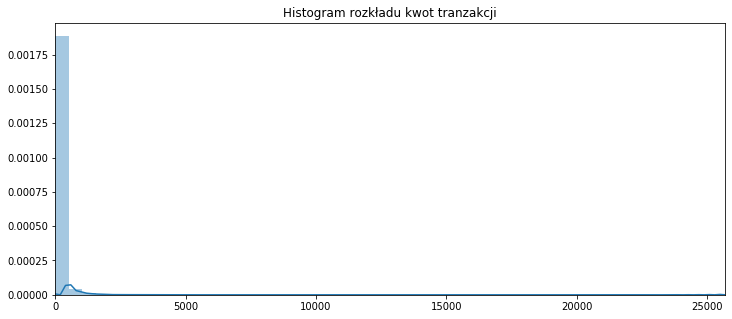

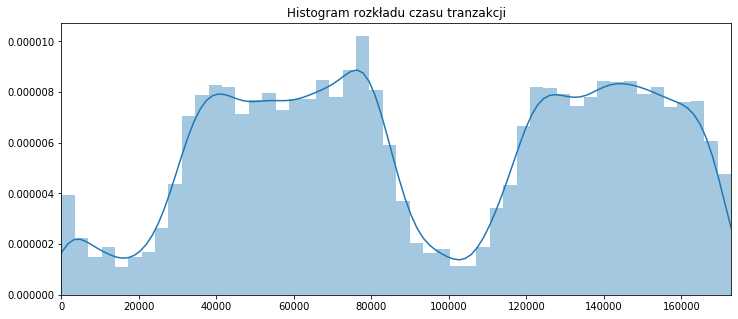

In [12]:
draw_histogram(df.Amount.values, 'Histogram rozkładu kwot tranzakcji')
draw_histogram(df.Time.values, 'Histogram rozkładu czasu tranzakcji')

#### Macierz korelacji 

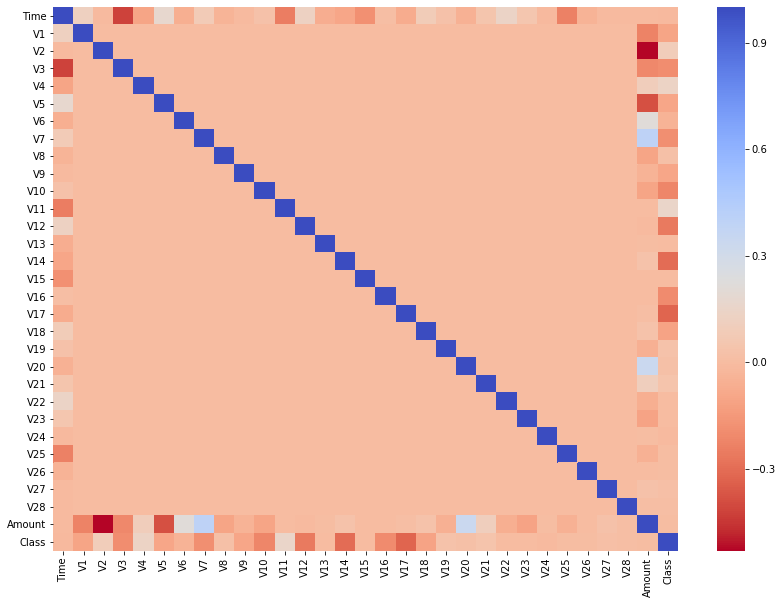

In [13]:
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

## 3) Preprocessing data 

W tej części skupie się na następujących działaniach:

    1) Wprowadzenie dodatkowej kolumny z danymi podbijającymi score modelu dla tranzakcji o wysokiej wartości
    2) Przeskalowanie wartości kwot i czasu - ponieważ nasze niewiadome 28 kolumn jest również przeskalowane, to ta czynność jest aż konieczna;
    3) Dostosowanie wielkości danych do wielkości zbioru oszustw - masz mode musi mieć jednakowe szanse na nauczenie się co jest oszustwem, a co nie
    4) Przygotowanie zbiorów treningowych i validacyjnych

#### Coefficient of valuable - Współczynnik Wartościowości
Zadanie poleda na tym, żeby wartościowe tranzakcje były bardziej brane pod uwagę jako oszustwa. Wyporzystamy do tego wzór
$$Coefficient\ of\ valuable\ = e^{\frac{Amount\times (1 + Class\times 5)}{2000}}$$
w którym im większa kwota tym większy współczynnik wartościowości. Jeśli podczas trenowania jakaś wartość została określona jako oszustwo, to jego wartość jest zwiększana 6 krotnie. Jako wartość graniczną ustawiamy 2000\$ . Jeśli przekroczy tą kwotę to współczynnik zacznie gwałtownie rosnąć

In [14]:
vec_amount = df.Amount.values
vec_class = df.Class.values

df['Coefficient_of_valuable'] = np.exp((vec_amount*(1+vec_class*5))/2000)

In [15]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Coefficient_of_valuable
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727,2.510466
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527,711.630582
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000,1.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000,1.002844
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000,1.011061
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000,1.039443
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000,379109.363315


#### Skalowanie

In [16]:
std_scaler = StandardScaler()

df['Scaler_amount'] = std_scaler.fit_transform(df.Amount.values.reshape(-1, 1))
df['Scaler_time'] = std_scaler.fit_transform(df.Time.values.reshape(-1, 1))
df['Scaler_CV'] = std_scaler.fit_transform(df.Coefficient_of_valuable.values.reshape(-1, 1))
df.drop(['Time','Amount', 'Coefficient_of_valuable'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time,Scaler_CV
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583,-0.002013
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583,-0.002121
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562,-0.001830
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562,-0.002033
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541,-0.002073


#### Dzielenie danych 

In [17]:
df_sample = df.sample(frac=1)

fraud_df = df_sample[df_sample.Class == 1]
non_fraud_df = df_sample[df_sample.Class == 0]
non_fraud_df = non_fraud_df[:492]
new_df = pd.concat([fraud_df, non_fraud_df])

print(new_df.shape)

new_df.head()

(984, 32)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Scaler_amount,Scaler_time,Scaler_CV
124176,-0.356326,1.435305,-0.813564,1.993117,2.055878,-0.543579,0.487691,0.085449,-0.536352,-2.231209,...,-0.267003,-1.158480,0.271460,-0.155397,0.114328,0.101526,1,-0.349231,-0.370869,-0.002118
247995,1.146259,1.403458,-4.159148,2.660107,-0.323217,-1.836071,-1.623740,0.259562,-1.132044,-3.356474,...,-0.141136,-0.265517,0.362260,-0.416062,0.507370,0.243744,1,-0.147848,1.241304,-0.001888
88897,-5.267760,2.506719,-5.290925,4.886134,-3.343188,-1.100085,-5.810509,1.726343,-0.749277,-4.834828,...,0.548482,-0.156850,-0.710187,-0.366423,-1.486766,0.677664,1,-0.348831,-0.683811,-0.002118
261473,-2.349340,1.512604,-2.647497,1.753792,0.406328,-2.188494,-0.686935,-0.547984,-0.099528,-1.672346,...,0.258148,0.061901,-0.354180,-1.152671,-0.736073,0.733703,1,-0.333639,1.373401,-0.002102
154693,-2.488363,4.359019,-7.776410,5.364027,-1.823877,-2.445140,-4.964221,1.484890,-2.947899,-7.175350,...,-0.266476,-0.370880,0.365535,0.081372,0.184983,-0.211582,1,-0.349231,0.164360,-0.002118


#### Ja teraz prezentuje się nasza macierz korelacji? 

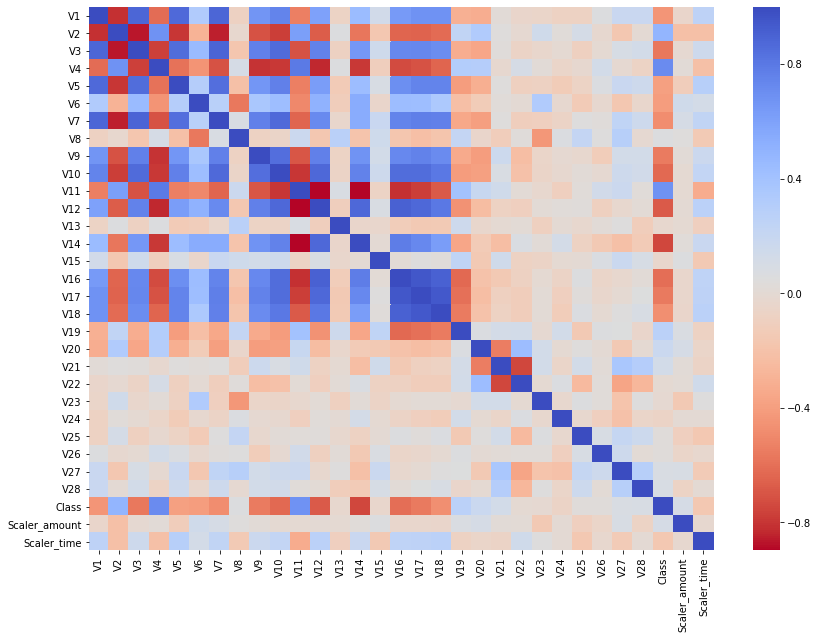

In [14]:
plt.figure(figsize=(14,10))
corr = new_df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

Można zauważyć, że teraz kolumny V4, V9, V10, V11, V12, V14 i V16 są skorelowane z kolumną Klasy(oszustw)

#### Przygotowanie zbiorów do uczenia 

In [18]:
X_data = new_df.drop('Class', axis=1)
y_data = new_df.Class

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.2, random_state=24601)

##  Classifiers - Klasyfikatory

### Logistic Regression - Regresja logistyczna
#### Training score

In [20]:
classifier = LogisticRegression(random_state=24601)
classifier.fit(X_train, y_train)
training_score_lr = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", round(training_score_lr.mean(),2)*100, '% accuracy')

Training score =  94.0 % accuracy


#### Confusion matrix

In [21]:
y_pred_lr = classifier.predict(X_train)
conf_matrix_lr = confusion_matrix(y_train, y_pred_lr)
conf_matrix_lr

array([[394,   6],
       [ 29, 358]], dtype=int64)

####  Looking for the best parameter

In [22]:
lr_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 "penalty": ['l1', 'l2']}
grid_lr = GridSearchCV(classifier, lr_parameters)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=24601, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
best_log_regression = grid_lr.best_estimator_
best_log_regression

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=24601, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
log_regression_score = cross_val_score(best_log_regression, X_train, y_train, cv=5)
print('Logistic Regression -> Cross Validation Score: ', 
      round(log_regression_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression -> Cross Validation Score:  95.3%


### K nearest neighbours - K najbliższych sąsiadów
#### Training score

In [25]:
classifier = KNeighborsClassifier()
classifier.fit(X_train, y_train)
training_score_knears = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", 
      round(training_score_knears.mean(),2)*100, '% accuracy')

Training score =  94.0 % accuracy


#### Confusion_matrix

In [26]:
y_pred_knears = classifier.predict(X_train)
conf_matrix_knears = confusion_matrix(y_train, y_pred_knears)
conf_matrix_knears

array([[397,   3],
       [ 35, 352]], dtype=int64)

####  Looking for the best parameter

In [27]:
knears_parameters = {"n_neighbors": [2,3,4,5,6,7], 
                     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(classifier, knears_parameters)
grid_knears.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
best_knears = grid_knears.best_estimator_
best_knears

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [29]:
knears_score = cross_val_score(best_knears, X_train, y_train, cv=5)
print('K Nearest Neighbours -> Cross Validation Score: ', 
      round(knears_score.mean() * 100, 2).astype(str) + '%')

K Nearest Neighbours -> Cross Validation Score:  93.78%


### Decision Tree  - Drzewa decyzyjne
#### Training score

In [30]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
training_score_tree = cross_val_score(classifier, X_train, y_train, cv=5)
print("Training score = ", 
      round(training_score_tree.mean(),2)*100, '% accuracy')

Training score =  92.0 % accuracy


#### Confusion_matrix

In [31]:
y_pred_tree = classifier.predict(X_train)
conf_matrix_tree = confusion_matrix(y_train, y_pred_tree)
conf_matrix_tree

array([[400,   0],
       [  0, 387]], dtype=int64)

#### Looking for the best parameter

In [32]:
tree_parameters = {"criterion": ["gini", "entropy"], 
                   "max_depth": list(range(2,9,1))}
grid_tree = GridSearchCV(classifier, tree_parameters)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
best_trees = grid_tree.best_estimator_
best_trees

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
tree_score = cross_val_score(best_trees, X_train, y_train, cv=5)
print('Decision Tree -> Cross Validation Score: ', 
      round(tree_score.mean() * 100, 2).astype(str) + '%')

Decision Tree -> Cross Validation Score:  93.77%


## Analysis and summary of collected results - Analiza i podsumowanie zebranych wyników 


### Training Score,  Cross validation score, 

In [35]:
print('% '*40)
print(' '*10)
print("For Logistic Regression, we got:")
print(' '*10)
print('Training score: {:.4f} %'.format(training_score_lr.mean()*100))
print('Cross validation score: {:.4f} %'.format(log_regression_score.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_train, y_pred_lr)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_train, y_pred_lr)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_train, y_pred_lr)*100))
print(' '*10)
print('% '*40)
print(' '*10)
print("For K nearest neighbours, we got:")
print(' '*10)
print('Training score: {:.4f} %'.format(training_score_knears.mean()*100))
print('Cross validation score: {:.4f} %'.format(knears_score.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_train, y_pred_knears)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_train, y_pred_knears)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_train, y_pred_knears)*100))
print(' '*40)
print('% '*40)
print(' '*10)
print("For Decision Tree, we got:")
print(' '*10)
print('Training score: {:.4f} %'.format(training_score_tree.mean()*100))
print('Cross validation score: {:.4f} %'.format(tree_score.mean()*100))
print('Recall Score: {:.4f} %'.format(recall_score(y_train, y_pred_tree)*100))
print('Precision Score: {:.4f} %'.format(precision_score(y_train, y_pred_tree)*100))
print('F1 Score: {:.4f} %'.format(f1_score(y_train, y_pred_tree)*100))
print(' '*10)
print('% '*40)

% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Logistic Regression, we got:
          
Training score: 94.2836 %
Cross validation score: 95.3003 %
Recall Score: 92.5065 %
Precision Score: 98.3516 %
F1 Score: 95.3395 %
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For K nearest neighbours, we got:
          
Training score: 93.6499 %
Cross validation score: 93.7773 %
Recall Score: 90.9561 %
Precision Score: 99.1549 %
F1 Score: 94.8787 %
                                        
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 
          
For Decision Tree, we got:
          
Training score: 92.1253 %
Cross validation score: 93.7741 %
Recall Score: 100.0000 %
Precision Score: 100.0000 %
F1 Score: 100.0000 %
          
% % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % % 


### Confusion matrix

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          size=5):
    """
    EN: Function to print and plot a confusion matrix
    PL: Funkcja do plotowania tablicy pomyłek 
    
    Parameters
    ----------
        cm: confusion matrix
        classes: type of category
        normalize=False: normalization of number, if you want it, write True
        title: str, title of figure
        cmap: palet of colours
        size: int, width of squere window
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(size,size))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

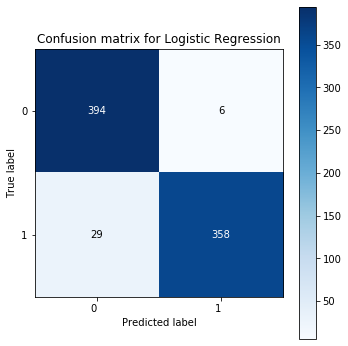

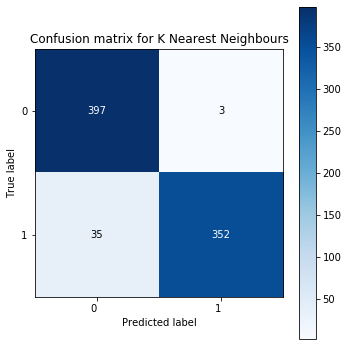

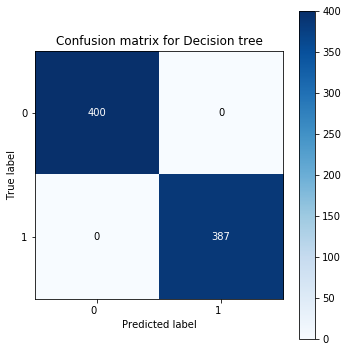

In [37]:
plot_confusion_matrix(conf_matrix_lr, classes=[0,1], 
                      title='Confusion matrix for Logistic Regression')
plot_confusion_matrix(conf_matrix_knears, classes=[0,1], 
                      title='Confusion matrix for K Nearest Neighbours')
plot_confusion_matrix(conf_matrix_tree, classes=[0,1], 
                      title='Confusion matrix for Decision tree')

### Learning curve 

In [38]:
def plot_learning_curve(model, X_data, y_data, cv, 
                        title, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5),
                        size=(12,5)):
    '''
    EN: Function for drawing a learning curve for training results and cross-validation.
    PL: Funkcja do rysowanie krzywej uczenia dla wyników treninowych oraz cross-validation.
    
    Parameters
    -----------
        model: fitting classifier
        X_data: dataset, with parameters for model
        y_data: dataset, with solution
        cv: int, cross-validation generator or an iterable
        n_jobs: int, Number of jobs to run in parallel
        train_sizes: array, Relative or absolute numbers of training 
                    examples that will be used to generate the learning curve
        size: (int,int), size of figure
    '''
    plt.figure(figsize=(size))
    plt.ylim = (0.80, 1.01)
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_data, y_data, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    plt.title(title)
    plt.xlabel('Training size')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(loc="best")

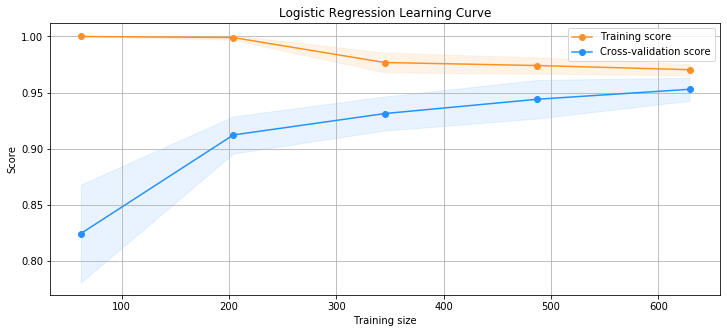

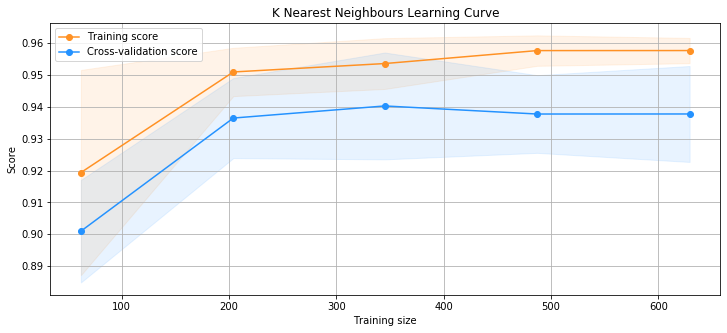

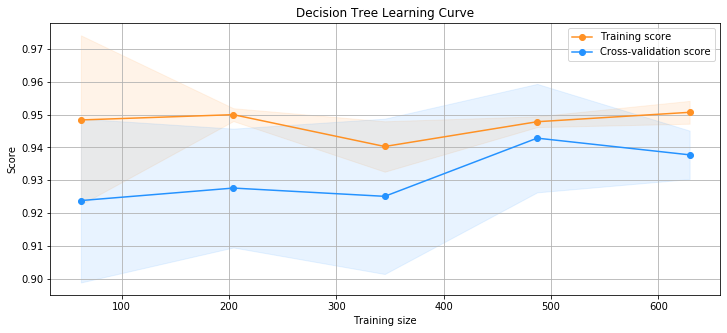

In [39]:
plot_learning_curve(best_log_regression, X_train, y_train, cv=5, title='Logistic Regression Learning Curve')
plot_learning_curve(best_knears, X_train, y_train, cv=5, title='K Nearest Neighbours Learning Curve')
plot_learning_curve(best_trees, X_train, y_train, cv=5, title='Decision Tree Learning Curve')

### ROC_curve 

In [40]:
def plot_roc_curve(vec_fpr, vec_tpr, vec_label, 
                   vec_roc_auc, title='ROC Curve'):
    '''
    EN: Function to plot many roc_curve on one figure
    PL: Funkcja do rysowania wielu roc_curve na jednym wykresie
    
    Parameters
    ----------
        vec_fpr: array, vector with fpr (false positive rate) for each models
        vec_tpr: array, vector with tpr (true positive rate) for each models
        vec_label: array of str, name models
        vec_roc_aus: array, values roc_auc for each models
        title: str, title of figure 'ROC Curve \n Top 4 Classifiers'
    '''
    plt.figure(figsize=(14,10))
    plt.title(title)
    
    for id_model in range(len(vec_label)):
        plt.plot(vec_fpr[id_model], vec_tpr[id_model], 
                 label=vec_label[id_model] + ' Classifier Score: {:.4f}'.format(vec_roc_auc[id_model]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', 
                 xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    plt.show()

In [41]:
log_reggresion_pred = cross_val_predict(best_log_regression, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(best_knears, X_train, y_train, cv=5)

tree_pred = cross_val_predict(best_trees, X_train, y_train, cv=5)

In [42]:
vec_pred = [log_reggresion_pred, knears_pred, tree_pred]

vec_fpr = []
vec_tpr = [] 
vec_roc_aus = []

for pred in vec_pred:
    fpr, tpr, thresold = roc_curve(y_train, pred)
    vec_fpr.append(fpr)
    vec_tpr.append(tpr)
    roc_aus = roc_auc_score(y_train, pred)
    vec_roc_aus.append(roc_aus)

vec_label = ['Logistic Regresion', 'K Nearest Neighbours', 'Desition tree']

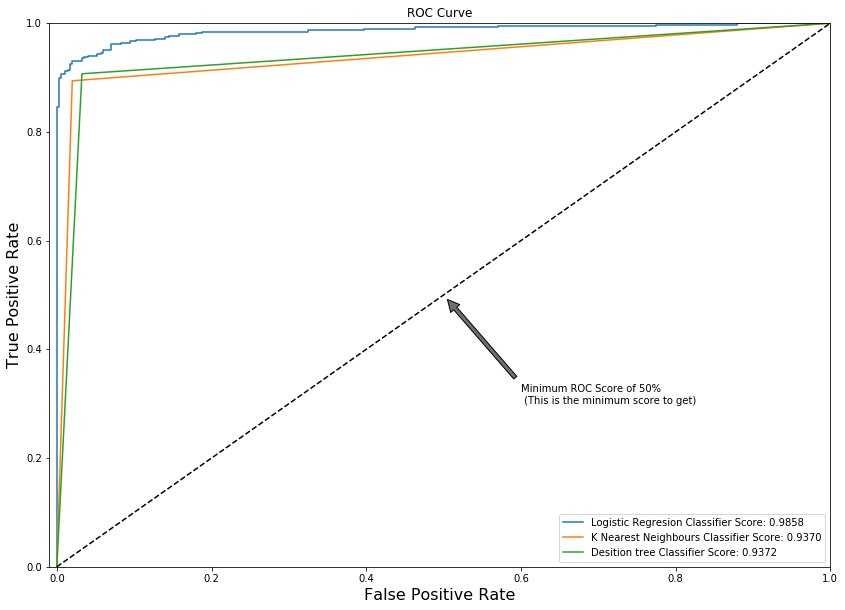

In [43]:
plot_roc_curve(vec_fpr, vec_tpr, vec_label, vec_roc_aus)